# Plot data with given time range and names

In [129]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.ticker import EngFormatter,MaxNLocator
import datetime
#import seaborn as sns
#sns.set()

# Set the time range

In [149]:
# time range in unit of day
_ = md.date2num(datetime.datetime.now())
xlimit = [_-1.1,_]
LOAD_CAP = False
LOAD_TEMP = True
LOAD_PRESSURE = True

# Get file list

In [150]:
# Bridge for still capacitance
dirBridge = r'C:\Impedance Bridge\Data'
pathListB = []
for i in sorted(os.listdir(dirBridge))[::-1]:
    _ = md.datestr2num(i.split(' ')[0])#start time of the file
    if _<xlimit[1]:
        print(i)
        pathListB.append(os.path.join(dirBridge,i))
        if _<xlimit[0]:
            break
            
# temperatures and pressures
dirAVS = r'C:\avs-47'
avslist = os.listdir(dirAVS)
pathListT = []
for i in sorted([x for x in avslist if 'LogAVS' in x and x!='LogAVS__zBridge_2014-09-04-11-39-58_1.dat'])[::-1]:
    _ = i.replace('.dat','').split('_')[-1]#something like '2014-09-04-11-39-58'
    _ = '%s-%s-%s %s:%s:%s'%tuple(_.split('-'))
    _ = md.datestr2num(_)#start time of the file
    if _<xlimit[1]:
        print(i)
        pathListT.append(os.path.join(dirAVS,i))
        if _<xlimit[0]:
            break
            
pathListP = []
for i in sorted([x for x in avslist if 'logFP' in x])[::-1]:
    _ = i.replace('.dat','').split('_')[-1]#something like '2014-09-04-11-39-58'
    _ = '%s-%s-%s %s:%s:%s'%tuple(_.split('-'))
    _ = md.datestr2num(_)#start time of the file
    if _<xlimit[1]:
        print(i)
        pathListP.append(os.path.join(dirAVS,i))
        if _<xlimit[0]:
            break


2020-12-31 Data set A.txt
2020-12-17 Data set A.txt
LogAVS___2020-12-27-17-41-55.dat
logFP___2020-12-27-17-41-53.dat


# Get the capacitance and show the average over the last 30 pts

In [151]:
_ = ['Time','Impedance','Calculated value','Frequency','Excitation','Chno','Measure type','Imp type']
headBridge = dict(zip(_,range(len(_))))
dBridge = None
if LOAD_CAP:
    for i in pathListB:
        _ = np.loadtxt(i,delimiter='\t',converters={0:lambda s: md.datestr2num(s.decode()),7:lambda s: int(s[0])})
        dBridge = _ if dBridge is None else np.append(_,dBridge,axis=0)
    _ = -30
    print('Average from: %s to %s, dt = %s'%(md.num2date(dBridge[_,0]),md.num2date(dBridge[-1,0]),md.num2date(dBridge[-1,0])-md.num2date(dBridge[_,0])))
    print('mean: %s, std: %s'%(np.mean(dBridge[_:,1])*1e12,np.std(dBridge[_:,1]*1e12)))

# Get the temperatures and the pressures

In [152]:
_ = ['Date', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'Flow', 'MG0', 'MG1', 'MG2', 'MG3', 'MG4', 'MG5', 'PT on', 'W_in', 'W_out', 'He', 'Oil', 'P_low', 'P_high', 'PT current', 'State0', 'State1', 'State2']
headFP = dict(zip(_,range(len(_))))
_ = ['Date1', 'Date2', 'R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'I0', 'I1', 'I2', 'I3']
headTC = dict(zip(_,range(len(_))))
dTC = None
if LOAD_TEMP:
    for i in pathListT:
        try:
            _ = np.loadtxt(i,delimiter='\t',converters = {0:lambda s: md.datestr2num(s.decode())})#sometimes the head is missing
        except:
            try:
                _ = np.loadtxt(i,delimiter='\t',converters = {0:lambda s: md.datestr2num(s.decode())},skiprows=4)
            except:
                print('Failed to load', i, os.stat(i).st_size/1000., 'k')
        dTC = _ if dTC is None else np.append(_,dTC,axis=0)
dFP = None
if LOAD_PRESSURE:
    for i in pathListP:
        try:
            _ = np.loadtxt(i,delimiter='\t',converters = {0:lambda s: md.datestr2num(s.decode())})
        except:
            try:
                _ = np.loadtxt(i,delimiter='\t',converters = {0:lambda s: md.datestr2num(s.decode())},skiprows=2)
            except:
                print('Failed to load', i, os.stat(i).st_size/1000., 'k')
        if len(np.shape(_))>1 and np.shape(_)[1] == 26:
            dFP = _ if dFP is None else np.append(_,dFP,axis=0)

Failed to load C:\avs-47\logFP___2020-12-27-17-41-53.dat 347.209 k


# set plotting parameters and plot

In [153]:
def plot_curve(ax,curve_name):
    caps = {'Impedance':'Cstill'}
    temps = {'T0':'3K','T1':'still','T2':'cold','T3':'MC','T5':'magnet'}
    pressures = {'Flow':'flow','P6':'He4','P7':'He3','P5':'P5','MG5':'still\n(mbar)','MG4':'IVC\n(mbar)'}
    if curve_name in caps:
        x = dBridge[:,headBridge['Time']]
        __ = 15
        _ = __*2 + 1#parameter for averaging
        lns = ax.plot(x,dBridge[:,headBridge[i]],label=caps[curve_name])
        lns = ax.plot(x[__:-__],np.convolve(dBridge[:,headBridge[i]],np.ones(_)/_,'valid'),label='smooth\n%s pts'%(_))
    elif curve_name in temps:
        x = dTC[:,headTC['Date1']]
        y = dTC[:,headTC[curve_name]]/1000.
        ax.plot(x,y,label=temps[curve_name])
    elif curve_name in pressures:
        x = dFP[:,headFP['Date']]
        y = dFP[:,headFP[curve_name]]
        ax.plot(x,y,'-',label=pressures[curve_name])

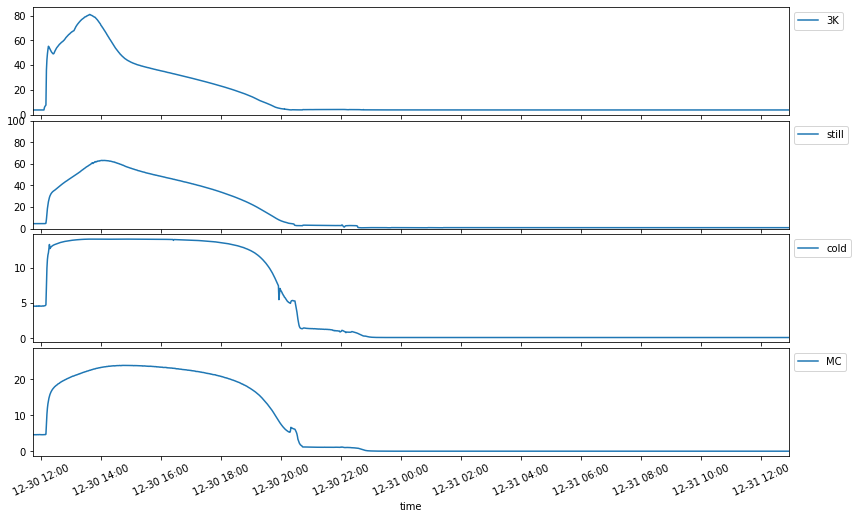

In [163]:
#{'Impedance':'Cstill'}
#{'T0':'3K','T1':'still','T2':'cold','T3':'MC','T5':'magnet'}
#{'Flow':'flow','P6':'He4','P7':'He3','P5':'P5'}
#{'P5':'P5'}#{'MG5':'still\n(mbar)','MG4':'IVC\n(mbar)'},
fig, axes = plt.subplots(4,1,figsize=(15, 8),sharex=True)
fig.subplots_adjust(hspace=0.05)

plot_curve(axes[0],'T0')
# axes[0].set_ylim(500,700)
plot_curve(axes[1],'T1')
axes[1].set_ylim(0,100)
plot_curve(axes[2],'T2')
plot_curve(axes[3],'T3')
# axes[3].set_ylim(0,0.3)

plt.subplots_adjust(bottom=0.1,right=0.8,left=0.1)

hour_interval = abs(xlimit[-1]-xlimit[0])/10
hour_interval = int(hour_interval)*24 if hour_interval>1 else int(hour_interval*24)
xfmt = md.DateFormatter('%m-%d %H:%M')
yfmt = EngFormatter()
for i in axes:
    i.legend(bbox_to_anchor=(1, 1),loc='upper left')
    i.yaxis.set_major_formatter(yfmt)
i.xaxis.set_major_formatter(xfmt)
i.xaxis.set_major_locator(md.HourLocator(interval=hour_interval))
plt.sca(i)
plt.xticks(rotation=25)
i.set_xlim(xlimit[0]+0.05,xlimit[1])
i.set_xlabel('time')
plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H.png"),dpi=300)
plt.show()

In [ ]:
# # interval of x axis, in hours
# hour_interval = abs(xlimit[-1]-xlimit[0])/10
# hour_interval = int(hour_interval)*24 if hour_interval>1 else int(hour_interval*24)
# # panel 0 always plot capacitance
# cv0={}#'Impedance':'Cstill'
# # panel 1
# cv1={}#{'T0':'3K','T1':'still','T2':'cold','T3':'MC','T5':'magnet'}
# # panel 2 has two axes
# cv2={'P5':'P5'}#{'Flow':'flow','P6':'He4','P7':'He3','P5':'P5'}
# cv3={}#{'P5':'P5'}#{'MG5':'still\n(mbar)','MG4':'IVC\n(mbar)'},
# # axes limits are modified below

# fig, arrAx = plt.subplots(3,1,figsize=(10, 8),sharex=True)
# fig.subplots_adjust(hspace=0.05)

# if dBridge is not None:
#     x = dBridge[:,headBridge['Time']]
#     __ = 15
#     _ = __*2 + 1#parameter for averaging

# # ax0, still capacitance
# for i in cv0:
#     lns = arrAx[0].plot(x,dBridge[:,headBridge[i]],label=cv0[i])
#     #arrAx[0].plot(dBridge2[:,headBridge['Time']],dBridge2[:,headBridge[i]],color=lns[0].get_color())
#     lns = arrAx[0].plot(x[__:-__],np.convolve(dBridge[:,headBridge[i]],np.ones(_)/_,'valid'),label='smooth\n%s pts'%(_))
#     #arrAx[0].plot(dBridge2[:,headBridge['Time']][__:-__],np.convolve(dBridge2[:,headBridge[i]],np.ones(_)/_,'valid'),color=lns[0].get_color())

# # ax1, T
# x = dTC[:,headTC['Date1']]
# for i in cv1:
#     arrAx[1].plot(x,dTC[:,headTC[i]]/1000.,label=cv1[i])
# arrAx[1].set_ylim(0,5)

# # ax2, P 
# x = dFP[:,headFP['Date']]
# for i in cv2:
#     arrAx[2].plot(x,dFP[:,headFP[i]],'-',label=cv2[i])
# arrAx[2].set_ylim(500,1000)
# #arrAx[2].set_yticks([0,200,400,600,800,1000,1200,1400])
# ax3 = arrAx[2].twinx()
# for i in cv3:
#     #ax3.semilogy(x,dFP[:,headFP[i]],label=cv3[i],color='r')
#     ax3.plot(x,dFP[:,headFP[i]],'-r',label=cv3[i])
# ax3.set_ylim(0.00049,0.00051)
# #ax3.set_ylim(1300,1500)

# plt.subplots_adjust(bottom=0.1,right=0.8,left=0.1)

# xfmt = md.DateFormatter('%y-%m-%d %H:%M')
# yfmt = EngFormatter()
# for i in arrAx:
#     i.xaxis.set_major_formatter(xfmt)
#     i.xaxis.set_major_locator(md.HourLocator(interval=hour_interval))
#     i.yaxis.set_major_formatter(yfmt)
#     i.legend(bbox_to_anchor=(1.25, 1),loc='upper right')
#     plt.sca(i)
#     plt.xticks(rotation=25)
# ax3.yaxis.set_major_formatter(yfmt)
# ax3.legend(bbox_to_anchor=(1.25, 0.5),loc='upper right')
# ax3.tick_params(which='both',axis='y', colors='red')
# ax3.set_xlim(*xlimit)

# i.set_xlim(*xlimit)
# i.set_xlabel('time')
# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H.png"),dpi=300)
# plt.show()